<a href="https://www.kaggle.com/code/abhishekguru/ka3-mlp?scriptVersionId=272710187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


In [2]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv")
test = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv")
train.sample(10)

,id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
25133,25133,McDonald's,Fast food restaurant,"9814 International Dr, Orlando, FL 32819, Unit...",28.423814,-81.461242,"5,468",a year ago,The outside seating area is nice and really li...,3
8091,8091,McDonald's,Fast food restaurant,"1698 US-209, Brodheadsville, PA 18322, United ...",40.922081,-75.399919,"1,028",3 years ago,Always super good my favorite restaurant all a...,5
20062,20062,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,808",3 years ago,"Ordered 3 sandwiches and received only bread, ...",1
15909,15909,McDonald's,Fast food restaurant,"10901 Riverside Dr, North Hollywood, CA 91602,...",34.152507,-118.367904,"1,795",7 years ago,Very happy. That old prejudice of food places ...,3
13562,13562,McDonald's,Fast food restaurant,"550 Lawrence Expy, Sunnyvale, CA 94086, United...",37.385495,-121.995421,"1,562",5 years ago,Ever time i come here on lunch i end up spendi...,1
398,398,McDonald's,Fast food restaurant,"1100 N US Hwy 377, Roanoke, TX 76262, United S...",33.009318,-97.222925,998,2 years ago,Excellent,5
15647,15647,McDonald's,Fast food restaurant,"621 Broadway, Newark, NJ 07104, United States",40.771910,-74.161475,"1,565",3 years ago,"The workers there are not professional,i went ...",2
16122,16122,McDonald's,Fast food restaurant,"1650 Washington Ave, Miami Beach, FL 33139, Un...",25.790295,-80.132077,"4,922",4 years ago,"Shocking service, staff didn't have a clue. Fo...",1
17392,17392,McDonald's,Fast food restaurant,"702-2 Haddonfield-Berlin Rd, Voorhees Township...",39.852059,-74.981099,933,a year ago,Good,4
10916,10916,McDonald's,Fast food restaurant,"72-69 Kissena Blvd, Queens, NY 11367, United S...",40.727401,-73.812460,"2,193",6 months ago,"Terrible Service!, You place and pay for your ...",1


# Exploratory data analysis:

In [4]:
train.shape

(26500, 10)

# (Indentification of datatypes, as per rubrics): 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26500 non-null  int64  
 1   store_name     26500 non-null  object 
 2   category       26500 non-null  object 
 3   store_address  26500 non-null  object 
 4   latitude       25976 non-null  float64
 5   longitude      25976 non-null  float64
 6   rating_count   26500 non-null  object 
 7   review_time    26500 non-null  object 
 8   review         26500 non-null  object 
 9   rating         26500 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB


# (Identification of null values as per rubrics, removed later in the preprocessing section): 

In [6]:
train.isnull().sum()

id                 0
store_name         0
category           0
store_address      0
latitude         524
longitude        524
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

In [7]:
train.isnull().sum()*100/len(train)

id               0.000000
store_name       0.000000
category         0.000000
store_address    0.000000
latitude         1.977358
longitude        1.977358
rating_count     0.000000
review_time      0.000000
review           0.000000
rating           0.000000
dtype: float64

In [8]:
train.nunique()

id               26500
store_name           2
category             1
store_address       40
latitude            39
longitude           39
rating_count        51
review_time         38
review           18328
rating               5
dtype: int64

# (Descriptive statistics as per rubrics):

In [9]:
train.describe()

,id,latitude,longitude,rating
count,26500.000000,25976.000000,25976.000000,26500.000000
mean,13249.500000,34.427152,-90.659226,3.130642
std,7650.035403,5.336112,16.588603,1.615425
min,0.000000,25.790295,-121.995421,1.000000
25%,6624.750000,28.655350,-97.792874,1.000000
50%,13249.500000,33.931261,-81.471414,3.000000
75%,19874.250000,40.727401,-75.399919,5.000000
max,26499.000000,44.981410,-73.459820,5.000000


# (Visualization as per rubrics):

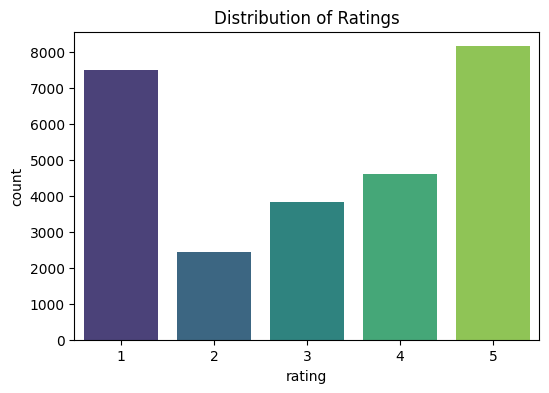

In [10]:
# Distribution of Ratings
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=train, palette="viridis")
plt.title("Distribution of Ratings")
plt.show()

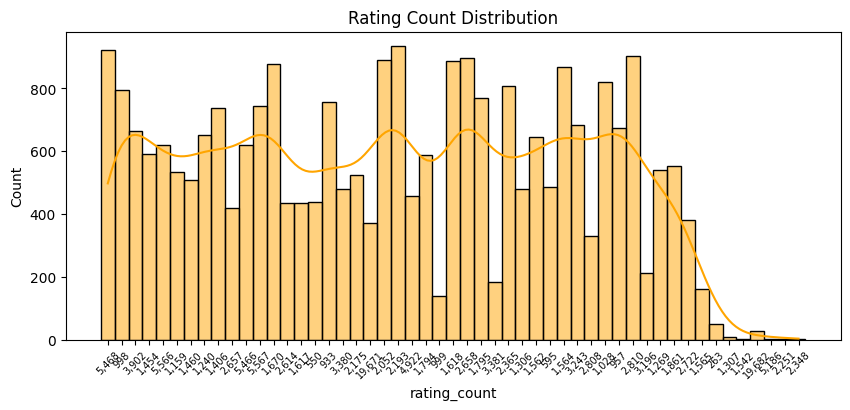

In [11]:
# Rating Count Distribution
plt.figure(figsize=(10,4))
sns.histplot(train["rating_count"], bins=30, kde=True, color="orange")
plt.title("Rating Count Distribution")
plt.xticks(rotation=45, fontsize=7)
plt.show()

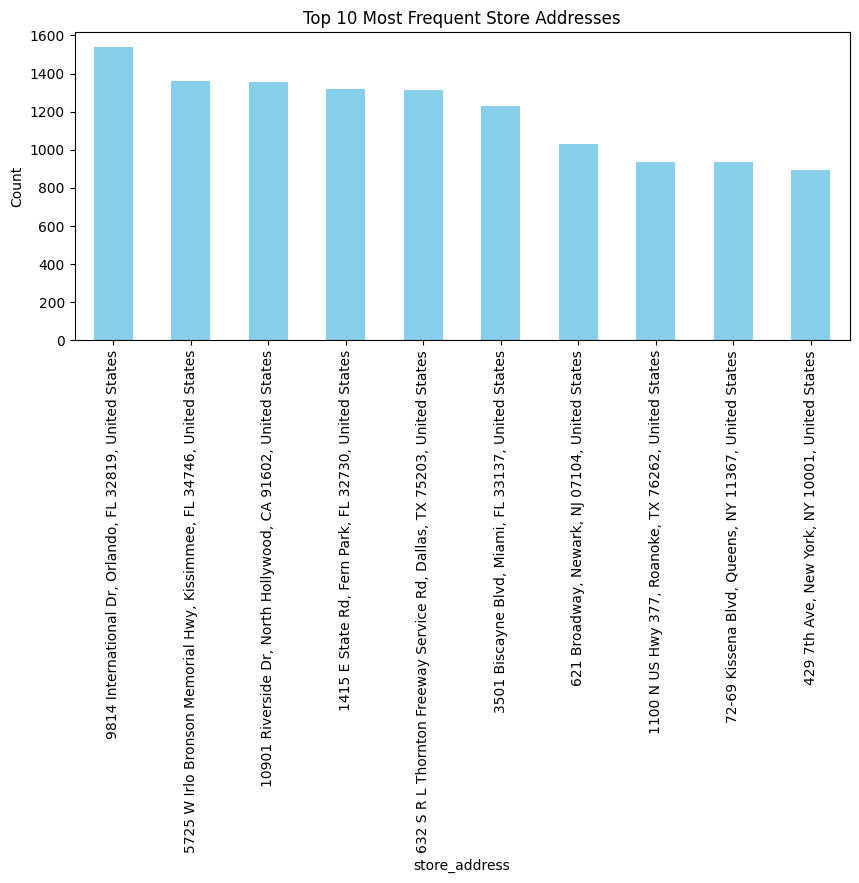

In [12]:
# Top 10 store addresses
plt.figure(figsize=(10,4))
train["store_address"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Most Frequent Store Addresses")
plt.ylabel("Count")
plt.show()

<Axes: >

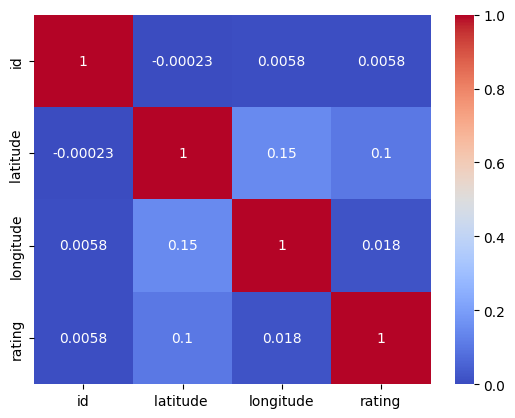

In [13]:
num_train = train.select_dtypes('number')
corr = num_train.corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm')

# (Identification and handling of outliers as per rubrics):

In [14]:
def identify_outliers_iqr(train, columns=None):
    
    if columns is None:
        columns = train.select_dtypes(include=['number']).columns

    outliers_dict = {}
    for col in columns:
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = train[(df[col] < lower) | (train[col] > upper)].index.tolist()
        outliers_dict[col] = outliers

    return outliers_dict

Since the values seen here can actually be useful for the model and tree-based models being more robust to outliers, removing them is not required in this case and might hurt performance. Hence, outliers are not being removed. 

# Feature Engineering:

In [15]:
def extract_zip(address):
    match = re.search(r"\b\d{5,6}\b", str(address))
    return match.group(0) if match else np.nan

train["zip_code"] = train["store_address"].apply(extract_zip)


In [16]:
train.nunique()

id               26500
store_name           2
category             1
store_address       40
latitude            39
longitude           39
rating_count        51
review_time         38
review           18328
rating               5
zip_code            36
dtype: int64

# Preprocessing

In [17]:
for df in (train, test):
    if "store_name" in df.columns:
        df.drop(columns=["store_name"], inplace=True)

In [18]:
train["rating_count"] = pd.to_numeric(train["rating_count"].astype(str).str.replace(",", ""), errors="coerce")
test["rating_count"]  = pd.to_numeric(test["rating_count"].astype(str).str.replace(",", ""), errors="coerce")

In [19]:
# Sanitizing column names for both train and test
for df in (train, test):
    df.columns = (
        df.columns.str.strip()        
                 .str.lower()         
                 .str.replace(' ', '_')  
    )

In [20]:
# Filling latitude/longitude missing with train mean
lat_mean = train["latitude"].astype(float).mean()
lon_mean = train["longitude"].astype(float).mean()
for df in (train, test):
    df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce").fillna(lat_mean)
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce").fillna(lon_mean)

# (Identification and removal of duplicates as per rubrics): 

In [21]:
#Removing an duplicate columns
train = train.loc[:, ~train.T.duplicated()]
test = test.loc[:, ~test.T.duplicated()]

In [22]:
def extract_zip(address):
    m = re.search(r"\b\d{5,6}\b", str(address))
    return m.group(0) if m else "Unknown"

for df in (train, test):
    df["zip_code"] = df["store_address"].apply(extract_zip)

In [23]:
# Dropping id from X but keeping in test for submission
train_ids = train["id"].values if "id" in train.columns else np.arange(len(train))
test_ids  = test["id"].values

In [24]:
# Dropping columns from X 
X = train.drop(columns=["id", "rating"], errors="ignore")
y = train["rating"].astype(int)

In [25]:
X_test_for_pred = test.drop(columns=["id"], errors="ignore")

In [26]:
# Shifting labels from [1,2,3,4,5] to [0,1,2,3,4] for classifiers like XGBoost ---
y = y - 1

X_test_for_pred = test.drop(columns=["id"], errors="ignore")

text_col = "review"
categorical_cols = [c for c in X.columns if X[c].dtype == "object" and c != text_col]
numerical_cols = [c for c in X.columns if c not in categorical_cols + [text_col]]

print("Text column:", text_col)
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Text column: review
Categorical columns: ['category', 'store_address', 'review_time', 'zip_code']
Numerical columns: ['latitude', 'longitude', 'rating_count']


# (TFIDF, Encoding and Scaling as per rubrics):

In [27]:
# 6. ColumnTransformer (TF-IDF + OHE + Scaler)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")

# OneHotEncoder 
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", tfidf, text_col),
        ("cat",  ohe, categorical_cols),
        ("num",  StandardScaler(), numerical_cols)
    ],
    remainder="drop",
    sparse_threshold=0.3  
)

# Model building (7 models)

In [28]:
# 7. Models to compare (classification)

models = {
    "LogisticRegression" : LogisticRegression(max_iter=1000),
    "RandomForest"       : RandomForestClassifier(n_estimators=200,random_state=42, n_jobs=-1),
    "ExtraTrees"         : ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting"   : GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost"            : XGBClassifier(n_estimators=200, use_label_encoder=False, verbosity=0, random_state=42),
    "LightGBM"           : LGBMClassifier(n_estimators=316, max_depth = 18, lr = 0.07, num_leaves = 176, subsample = 0.86, colsample = 0.67, verbose=-1, random_state=42),
    "CatBoost"           : CatBoostClassifier(iterations=200, verbose=0, random_state=42)
}


In [29]:
# 8. Train/validation split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Model evaluation and comparison as per rubrics: 

In [30]:
# 9. Fitting & evaluating each model

results = []
for name, clf in models.items():
    print(f"\nTraining & evaluating: {name}")
    pipe = Pipeline([("preproc", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results.append({"model": name, "accuracy": acc})
    print(f"{name} accuracy: {acc:.4f}")

results_df = pd.DataFrame(results).sort_values("accuracy", ascending=False).reset_index(drop=True)
print("\nModel comparison (validation set):")
print(results_df)



Training & evaluating: LogisticRegression
LogisticRegression accuracy: 0.6528

Training & evaluating: RandomForest
RandomForest accuracy: 0.6874

Training & evaluating: ExtraTrees
ExtraTrees accuracy: 0.6819

Training & evaluating: GradientBoosting
GradientBoosting accuracy: 0.6340

Training & evaluating: XGBoost
XGBoost accuracy: 0.6704

Training & evaluating: LightGBM
LightGBM accuracy: 0.6813

Training & evaluating: CatBoost
CatBoost accuracy: 0.6366

Model comparison (validation set):
                model  accuracy
0        RandomForest  0.687358
1          ExtraTrees  0.681887
2            LightGBM  0.681321
3             XGBoost  0.670377
4  LogisticRegression  0.652830
5            CatBoost  0.636604
6    GradientBoosting  0.633962


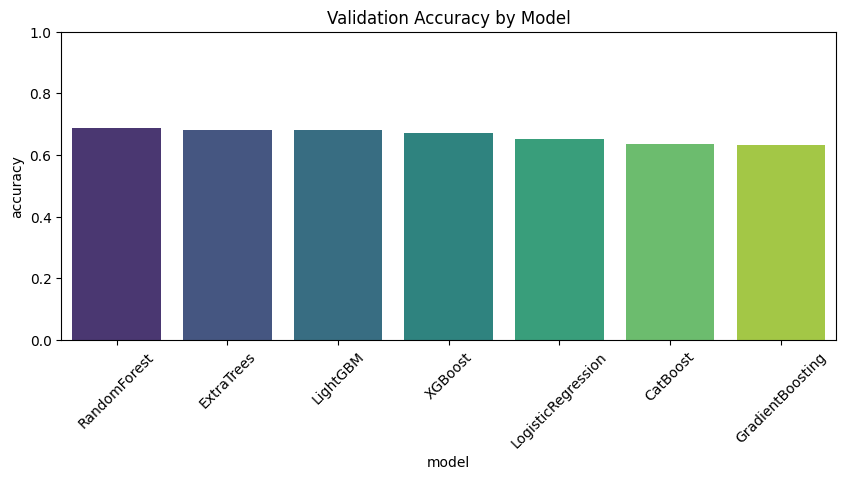

In [31]:
# Visualizing comparison
plt.figure(figsize=(10,4))
sns.barplot(data=results_df, x="model", y="accuracy", palette="viridis")
plt.xticks(rotation=45)
plt.title("Validation Accuracy by Model")
plt.ylim(0, 1)
plt.show()


# Hyperparameter tuning with Optuna (for three base models and the meta-model):

(Commented to avoid multiple runs, because this is computationally very expensive.)

In [32]:
# from sklearn.ensemble import StackingClassifier
# import optuna

# # Picking top 3 models from validation results
# top3_model_names = results_df.head(3)["model"].tolist()
# print("Top 3 models for stacking:", top3_model_names)


# # ---------- STEP 1: Tuning each base model with only 3 key hyperparameters ----------
# def tune_single_model(name, n_trials=30):
#     def objective(trial):
#         if name == "RandomForest":
#             model = RandomForestClassifier(
#                 n_estimators=200,
#                 max_depth=trial.suggest_int("max_depth", 5, 50),
#                 min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
#                 random_state=42, n_jobs=-1
#             )

#         elif name == "ExtraTrees":
#             model = ExtraTreesClassifier(
#                 n_estimators=200,
#                 max_depth=trial.suggest_int("max_depth", 5, 50),
#                 min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
#                 random_state=42, n_jobs=-1
#             )

#         elif name == "LightGBM":
#             model = LGBMClassifier(
#                 n_estimators=trial.suggest_int("n_estimators", 100, 500),
#                 max_depth=trial.suggest_int("max_depth", -1, 20),
#                 learning_rate=trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
#                 random_state=42, n_jobs=-1
#             )
#         else:
#             raise ValueError(f"Unknown model: {name}")

#         pipe = Pipeline([
#             ("preproc", preprocessor),
#             ("clf", model)
#         ])
#         return cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()

#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=n_trials)
#     print(f"Best params for {name}: {study.best_params}")
#     print(f"Best CV score for {name}: {study.best_value:.4f}")
#     return study.best_params


# # Tuning base models
# best_params_dict = {}
# for model_name in top3_model_names:
#     best_params_dict[model_name] = tune_single_model(model_name, n_trials=50)


# # ---------- STEP 2: Building final tuned base models ----------
# def build_final_model(name, params):
#     if name == "RandomForest":
#         return RandomForestClassifier(**params, random_state=42, n_jobs=-1)
#     elif name == "ExtraTrees":
#         return ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)
#     elif name == "LightGBM":
#         return LGBMClassifier(**params, random_state=42, n_jobs=-1)
#     else:
#         raise ValueError(f"Unknown model: {name}")

# final_estimators = [(name, build_final_model(name, best_params_dict[name])) for name in top3_model_names]


# # ---------- STEP 3: Tuning XGBoost meta-classifier with 3 key hyperparams ----------
# def objective_meta_xgb(trial):
#     meta_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 300),
#         "max_depth": trial.suggest_int("max_depth", 2, 6),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "use_label_encoder": False,
#         "eval_metric": "logloss",
#         "random_state": 42,
#         "n_jobs": -1
#     }

#     meta_clf = XGBClassifier(**meta_params)

#     stack_clf = StackingClassifier(
#         estimators=final_estimators,
#         final_estimator=meta_clf,
#         passthrough=True,
#         cv=3,
#         n_jobs=-1
#     )

#     pipe = Pipeline([
#         ("preproc", preprocessor),
#         ("stack", stack_clf)
#     ])
#     return cross_val_score(pipe, X_train, y_train, cv=3, scoring="accuracy").mean()


# # Running meta tuning
# meta_study = optuna.create_study(direction="maximize")
# meta_study.optimize(objective_meta_xgb, n_trials=20)

# print("Best XGB meta params:", meta_study.best_params)
# print("Best meta CV score:", meta_study.best_value)


In [33]:
from sklearn.ensemble import StackingClassifier

# Picking top 3 models from validation results
top3_model_names = results_df.head(3)["model"].tolist()
print("Top 3 models for stacking:", top3_model_names)

# Preparing estimators list for StackingClassifier
estimators = [(name, models[name]) for name in top3_model_names]

# Logistic regression as Meta-classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator= XGBClassifier(n_estimators=113, max_depth = 4, learning_rate = 0.073,  use_label_encoder=False, verbosity=0, random_state=42),
    cv=5,               
    n_jobs=-1,
    passthrough=True    
)

# Building pipeline with the preprocessor
stacking_pipe = Pipeline([
    ("preproc", preprocessor),
    ("stack", stacking_clf)
])

# Training on training data
stacking_pipe.fit(X_train, y_train)

# Validating
stack_val_preds = stacking_pipe.predict(X_val)
stack_val_acc = accuracy_score(y_val, stack_val_preds)
print(f"Stacking top 3 models validation accuracy: {stack_val_acc:.4f}")


Top 3 models for stacking: ['RandomForest', 'ExtraTrees', 'LightGBM']
Stacking top 3 models validation accuracy: 0.7057


In [34]:
results_df = pd.concat([
    results_df,
    pd.DataFrame([{"model": "StackingTop3", "accuracy": stack_val_acc}])
], ignore_index=True).sort_values("accuracy", ascending=False).reset_index(drop=True)

print("\nUpdated Model Comparison (with stacking):")
print(results_df)


Updated Model Comparison (with stacking):
                model  accuracy
0        StackingTop3  0.705660
1        RandomForest  0.687358
2          ExtraTrees  0.681887
3            LightGBM  0.681321
4             XGBoost  0.670377
5  LogisticRegression  0.652830
6            CatBoost  0.636604
7    GradientBoosting  0.633962


In [35]:
# Retraining on full training set for submission
stacking_pipe.fit(X, y)
test_preds = stacking_pipe.predict(X_test_for_pred)
test_preds_orig = test_preds + 1

In [36]:
# Building submission
submission = pd.DataFrame({"id": range(0,test.shape[0]), "rating": test_preds_orig})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
